The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3
!pip install "setuptools==66"
!pip install "wheel==0.38.4"
!pip install "gym==0.21.0"


# Q-Learning
:label:`sec_qlearning`

In the previous section, we discussed the Value Iteration algorithm which requires accessing the complete Markov decision process (MDP), e.g., the transition and reward functions. In this section, we will look at Q-Learning :cite:`Watkins.Dayan.1992` which is an algorithm to learn the value function without necessarily knowing the MDP. This algorithm embodies the central idea behind reinforcement learning: it will enable the robot to obtain its own data.
<!-- , instead of relying upon the expert. -->

## The Q-Learning Algorithm

Recall that value iteration for the action-value function in :ref:`sec_valueiter` corresponds to the update

$$Q_{k+1}(s, a) = r(s, a) + \gamma \sum_{s' \in \mathcal{S}} P(s' \mid s, a) \max_{a' \in \mathcal{A}} Q_k (s', a'); \ \textrm{for all } s \in \mathcal{S} \textrm{ and } a \in \mathcal{A}.$$

As we discussed, implementing this algorithm requires knowing the MDP, specifically the transition function $P(s' \mid s, a)$. The key idea behind Q-Learning is to replace the summation over all $s' \in \mathcal{S}$ in the above expression by a summation over the states visited by the robot. This allows us to subvert the need to know the transition function.

## An Optimization Problem Underlying Q-Learning

Let us imagine that the robot uses a policy $\pi_e(a \mid s)$ to take actions. Just like the previous chapter, it collects a dataset of $n$ trajectories of $T$ timesteps each $\{ (s_t^i, a_t^i)_{t=0,\ldots,T-1}\}_{i=1,\ldots, n}$. Recall that value iteration is really a set of constraints that ties together the action-value $Q^*(s, a)$ of different states and actions to each other. We can implement an approximate version of value iteration using the data that the robot has collected using $\pi_e$ as

$$\hat{Q} = \min_Q \underbrace{\frac{1}{nT} \sum_{i=1}^n \sum_{t=0}^{T-1} (Q(s_t^i, a_t^i) - r(s_t^i, a_t^i) - \gamma \max_{a'} Q(s_{t+1}^i, a'))^2}_{\stackrel{\textrm{def}}{=} \ell(Q)}.$$
:eqlabel:`q_learning_optimization_problem`

Let us first observe the similarities and differences between this expression and value iteration above. If the robot's policy $\pi_e$ were equal to the optimal policy $\pi^*$, and if it collected an infinite amount of data, then this optimization problem would be identical to the optimization problem underlying value iteration. But while value iteration requires us to know $P(s' \mid s, a)$, the optimization objective does not have this term. We have not cheated: as the robot uses the policy $\pi_e$ to take an action $a_t^i$ at state $s_t^i$, the next state $s_{t+1}^i$ is a sample drawn from the transition function. So the optimization objective also has access to the transition function, but implicitly in terms of the data collected by the robot.

The variables of our optimization problem are $Q(s, a)$ for all $s \in \mathcal{S}$ and $a \in \mathcal{A}$. We can minimize the objective using gradient descent. For every pair $(s_t^i, a_t^i)$ in our dataset, we can write

$$\begin{aligned}Q(s_t^i, a_t^i) &\leftarrow Q(s_t^i, a_t^i) - \alpha \nabla_{Q(s_t^i,a_t^i)} \ell(Q) \\&=(1 - \alpha) Q(s_t^i,a_t^i) - \alpha \Big( r(s_t^i, a_t^i) + \gamma \max_{a'} Q(s_{t+1}^i, a') \Big),\end{aligned}$$
:eqlabel:`q_learning`

where $\alpha$ is the learning rate. Typically in real problems, when the robot reaches the goal location, the trajectories end. The value of such a terminal state is zero because the robot does not take any further actions beyond this state. We should modify our update to handle such states as

$$Q(s_t^i, a_t^i) =(1 - \alpha) Q(s_t^i,a_t^i) - \alpha \Big( r(s_t^i, a_t^i) + \gamma (1 - \mathbb{1}_{s_{t+1}^i \textrm{ is terminal}} )\max_{a'} Q(s_{t+1}^i, a') \Big).$$

where $\mathbb{1}_{s_{t+1}^i \textrm{ is terminal}}$ is an indicator variable that is one if $s_{t+1}^i$ is a terminal state and zero otherwise. The value of state-action tuples $(s, a)$ that are not a part of the dataset is set to $-\infty$. This algorithm is known as Q-Learning.

Given the solution of these updates $\hat{Q}$, which is an approximation of the optimal value function $Q^*$, we can obtain the optimal deterministic policy corresponding to this value function easily using

$$\hat{\pi}(s) = \mathrm{argmax}_{a} \hat{Q}(s, a).$$

There can be situations when there are multiple deterministic policies that correspond to the same optimal value function; such ties can be broken arbitrarily because they have the same value function.

## Exploration in Q-Learning

The policy used by the robot to collect data $\pi_e$ is critical to ensure that Q-Learning works well. Afterall, we have replaced the expectation over $s'$ using the transition function $P(s' \mid s, a)$ using the data collected by the robot. If the policy $\pi_e$ does not reach diverse parts of the state-action space, then it is easy to imagine our estimate $\hat{Q}$ will be a poor approximation of the optimal $Q^*$. It is also important to note that in such a situation, the estimate of $Q^*$ at *all states* $s \in \mathcal{S}$ will be bad, not just the ones visited by $\pi_e$. This is because the Q-Learning objective (or value iteration) is a constraint that ties together the value of all state-action pairs. It is therefore critical to pick the correct policy $\pi_e$ to collect data.

We can mitigate this concern by picking a completely random policy $\pi_e$ that samples actions uniformly randomly from $\mathcal{A}$. Such a policy would visit all states, but it will take a large number of trajectories before it does so.

We thus arrive at the second key idea in Q-Learning, namely exploration. Typical implementations of Q-Learning tie together the current estimate of $Q$ and the policy $\pi_e$ to set

$$\pi_e(a \mid s) = \begin{cases}\mathrm{argmax}_{a'} \hat{Q}(s, a') & \textrm{with prob. } 1-\epsilon \\ \textrm{uniform}(\mathcal{A}) & \textrm{with prob. } \epsilon,\end{cases}$$
:eqlabel:`epsilon_greedy`

where $\epsilon$ is called the "exploration parameter" and is chosen by the user. The policy $\pi_e$ is called an exploration policy. This particular $\pi_e$ is called an $\epsilon$-greedy exploration policy because it chooses the optimal action (under the current estimate $\hat{Q}$) with probability $1-\epsilon$ but explores randomly with the remainder probability $\epsilon$. We can also use the so-called softmax exploration policy

$$\pi_e(a \mid s) = \frac{e^{\hat{Q}(s, a)/T}}{\sum_{a'} e^{\hat{Q}(s, a')/T}};$$

where the hyper-parameter $T$ is called temperature. A large value of $\epsilon$ in $\epsilon$-greedy policy functions similarly to a large value of temperature $T$ for the softmax policy.

It is important to note that when we pick an exploration that depends upon the current estimate of the action-value function $\hat{Q}$, we need to resolve the optimization problem periodically. Typical implementations of Q-Learning make one mini-batch update using a few state-action pairs in the collected dataset (typically the ones collected from the previous timestep of the robot) after taking every action using $\pi_e$.

## The "Self-correcting" Property of Q-Learning

The dataset collected by the robot during Q-Learning grows with time. Both the exploration policy $\pi_e$ and the estimate $\hat{Q}$ evolve as the robot collects more data. This gives us a key insight into why Q-Learning works well. Consider a state $s$: if a particular action $a$ has a large value under the current estimate $\hat{Q}(s,a)$, then both the $\epsilon$-greedy and the softmax exploration policies have a larger probability of picking this action. If this action actually is *not* the ideal action, then the future states that arise from this action will have poor rewards. The next update of the Q-Learning objective will therefore reduce the value $\hat{Q}(s,a)$, which will reduce the probability of picking this action the next time the robot visits state $s$. Bad actions, e.g., ones whose value is overestimated in $\hat{Q}(s,a)$, are explored by the robot but their value is correct in the next update of the Q-Learning objective. Good actions, e.g., whose value $\hat{Q}(s, a)$ is large, are explored more often by the robot and thereby reinforced. This property can be used to show that Q-Learning can converge to the optimal policy even if it begins with a random policy $\pi_e$ :cite:`Watkins.Dayan.1992`.

This ability to not only collect new data but also collect the right kind of data is the central feature of reinforcement learning algorithms, and this is what distinguishes them from supervised learning. Q-Learning, using deep neural networks (which we will see in the DQN chapeter later), is responsible for the resurgence of reinforcement learning :cite:`mnih2013playing`.

## Implementation of Q-Learning

We now show how to implement Q-Learning on FrozenLake from [Open AI Gym](https://gym.openai.com). Note this is the same setup as we consider in :ref:`sec_valueiter` experiment.


In [1]:
%matplotlib inline
import random
import numpy as np
from d2l import torch as d2l

seed = 0  # Random number generator seed
gamma = 0.95  # Discount factor
num_iters = 256  # Number of iterations
alpha   = 0.9  # Learing rate
epsilon = 0.9  # Epsilon in epsilion gready algorithm
random.seed(seed)  # Set the random seed
np.random.seed(seed)

# Now set up the environment
env_info = d2l.make_env('FrozenLake-v1', seed=seed)

In the FrozenLake environment, the robot moves on a $4 \times 4$ grid (these are the states) with actions that are "up" ($\uparrow$), "down" ($\rightarrow$), "left" ($\leftarrow$), and "right" ($\rightarrow$). The environment contains a number of holes (H) cells and frozen (F) cells as well as a goal cell (G), all of which are unknown to the robot. To keep the problem simple, we assume the robot has reliable actions, i.e. $P(s' \mid s, a) = 1$ for all $s \in \mathcal{S}, a \in \mathcal{A}$. If the robot reaches the goal, the trial ends and the robot receives a reward of $1$ irrespective of the action; the reward at any other state is $0$ for all actions. The objective of the robot is to learn a policy that reaches the goal location (G) from a given start location (S) (this is $s_0$) to maximize the *return*.

We first implement $\epsilon$-greedy method as follows:


In [2]:
def e_greedy(env, Q, s, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()

    else:
        return np.argmax(Q[s,:])

We are now ready to implement Q-learning:


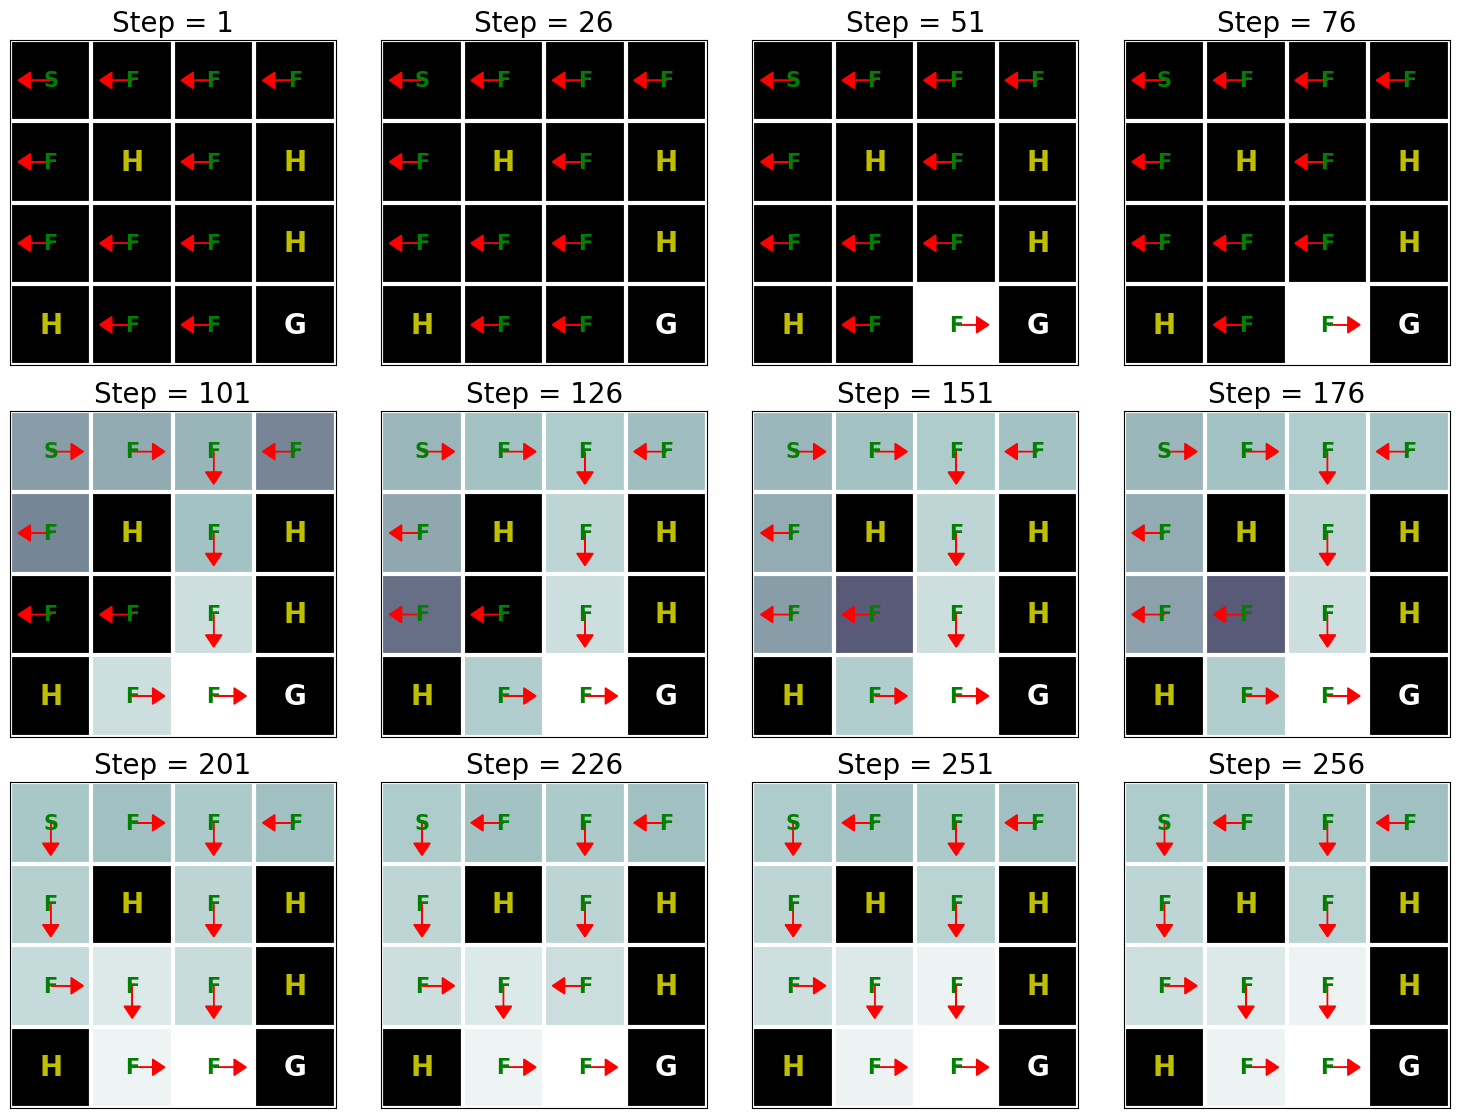

In [3]:
def q_learning(env_info, gamma, num_iters, alpha, epsilon):
    env_desc = env_info['desc']  # 2D array specifying what each grid item means
    env = env_info['env']  # 2D array specifying what each grid item means
    num_states = env_info['num_states']
    num_actions = env_info['num_actions']

    Q  = np.zeros((num_states, num_actions))
    V  = np.zeros((num_iters + 1, num_states))
    pi = np.zeros((num_iters + 1, num_states))

    for k in range(1, num_iters + 1):
        # Reset environment
        state, done = env.reset(), False
        while not done:
            # Select an action for a given state and acts in env based on selected action
            action = e_greedy(env, Q, state, epsilon)
            next_state, reward, done, _ = env.step(action)

            # Q-update:
            y = reward + gamma * np.max(Q[next_state,:])
            Q[state, action] = Q[state, action] + alpha * (y - Q[state, action])

            # Move to the next state
            state = next_state
        # Record max value and max action for visualization purpose only
        for s in range(num_states):
            V[k,s]  = np.max(Q[s,:])
            pi[k,s] = np.argmax(Q[s,:])
    d2l.show_Q_function_progress(env_desc, V[:-1], pi[:-1])

q_learning(env_info=env_info, gamma=gamma, num_iters=num_iters, alpha=alpha, epsilon=epsilon)

This result shows that Q-learning can find the optimal solution for this problem roughly after 250 iterations. However, when we compare this result with the Value Iteration algorithm's result (see :ref:`subsec_valueitercode`), we can see that the Value Iteration algorithm needs way fewer iterations to find the optimal solution for this problem. This happens because the Value Iteration algorithm has access to the full MDP whereas Q-learning does not.


## Summary
Q-learning is one of the most fundamental reinforcement-learning algorithms. It has been at the epicenter of the recent success of reinforcement learning, most notably in learning to play video games :cite:`mnih2013playing`. Implementing Q-learning does not require that we know the Markov decision process (MDP), e.g., the transition and reward functions, completely.

## Exercises

1. Try increasing the grid size to $8 \times 8$. Compared with $4 \times 4$ grid, how many iterations does it take to find the optimal value function?
1. Run the Q-learning algorithm again with $\gamma$ (i.e. "gamma" in the above code) when it equals to $0$, $0.5$, and $1$ and analyze its results.
1. Run the Q-learning algorithm again with $\epsilon$ (i.e. "epsilon" in the above code) when it equals to $0$, $0.5$, and $1$ and analyze its results.


[Discussions](https://discuss.d2l.ai/t/12103)
